In [5]:
import os
import getpass
from itertools import groupby
import fitz
import sddk
from webdav3.client import Client

In [6]:
options = {
 'webdav_hostname': "https://sciencedata.dk/files",
 'webdav_login':    "648597@au.dk",
 'webdav_password': getpass.getpass("insert password")
}
sd = Client(options)

insert password········


In [7]:
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [8]:
#### https://pymupdf.readthedocs.io/en/latest/faq/#how-to-extract-text-from-within-a-rectangle

In [9]:
mydir = "a_DOCS/"
test_file = "Boyer_2018_Minds-Make-Societies_ntvk.pdf"

In [10]:
resp = conf[0].get(conf[1] + mydir + test_file)

In [11]:
pages = fitz.open(stream=resp.content, filetype="pdf")

In [12]:
pages.metadata

{'format': 'PDF 1.4',
 'title': 'Minds Make Societies',
 'author': 'Pascal Boyer',
 'subject': None,
 'keywords': None,
 'creator': 'calibre 3.26.1 [https://calibre-ebook.com]',
 'producer': 'calibre 3.26.1 [https://calibre-ebook.com]',
 'creationDate': "D:20180909085252+00'00'",
 'modDate': "D:20190718080056+02'00'",
 'encryption': None}

In [13]:
all_docs = sd.list("a_DOCS")
all_pdfs = [doc for doc in all_docs if (doc[0] != ".") and (".pdf" in doc)]

In [ ]:
docs_annots = []
for doc in all_pdfs[:30]:
    annots_objects = []
    resp = conf[0].get(conf[1] + mydir + doc)
    for page in fitz.open(stream=resp.content, filetype="pdf"):
        for annot in page.annots():            
            annots_objects.append(annot)
    if len(annots_objects) > 0:
        docs_annots.append(doc)
len(docs_annots)

mupdf: cannot recognize version marker


In [16]:
# extract vertices and rectangles for all annotations
annots = []
annots_objects = []
annot_n = 0
for page in pages:
    for annot in page.annots():
        annots_objects.append(annot)
        vertices = annot.vertices
        rect = annot.rect
        annot_text = get_annot_text(vertices, rect, words)
        annot_n += 1
        annots.append({"text" : annot_text,  "page" : page.number, "annot" : annot_n})  

NameError: name 'get_annot_text' is not defined

In [19]:
pages[21].number

21

In [375]:
def get_ver_corners(vertices):
    first_line_left = min(vertices, key = lambda tup: (tup[1], tup[0])) # min y, then min x
    first_line_left = (first_line_left[0] - 0.1, first_line_left[1] - 0.1)
    last_line_right = max(vertices, key = lambda tup: (tup[1], tup[0])) # max y, then max x
    last_line_right = (last_line_right[0] + 0.1, last_line_right[1] + 0.1)
    return fitz.Rect(first_line_left, last_line_right)

In [376]:
def get_page_words(page):
    words = page.getText("words")  # list of words on page
    words.sort(key=lambda w: (w[3], w[0]))  # ascending y, then x coordinate
    return words

In [377]:
def str_from_rect(any_rect, words, method="inter"):
    if method == "in": # it does not work well in most cases
        mywords = [w for w in words if fitz.Rect(w[:4]) in any_rect]# if fitz.Rect(w[:4]) 
    else:
        mywords = [w for w in words if fitz.Rect(w[:4]).intersects(rect)]# if fitz.Rect(w[:4]) 
    group = groupby(mywords, key=lambda w: w[3])
    annot_text = ""
    for y1, gwords in group:
        annot_text = annot_text + " " + " ".join(w[4] for w in gwords)
    annot_text = " ".join(annot_text.split())
    return annot_text

In [380]:
def get_annot_text(vertices, rect, words):
    corners = get_ver_corners(vertices)
    str_by_vertices = str_from_rect(corners, words)
    str_by_rect = str_from_rect(rect, words)
    #test = "ok"
    #if test == "ok":   
    if str_by_vertices != str_by_rect:
        start, end = str_by_vertices[:5], str_by_vertices[-5:]
        try: 
            str_reduced = re.search('%s.*%s' % (start, end), str_by_rect)[0]
        except: 
            str_reduced = str_by_rect
        return str_reduced
    else:
        return str_by_rect

In [383]:
# extract vertices and rectangles for all annotations
annots = []
annots_objects = []
annot_n = 0
for page in pages:
    try: 
        words = get_page_words(page)
    except: 
        words = ""
    for annot in page.annots():
        annots_objects.append(annot)
        vertices = annot.vertices
        rect = annot.rect
        annot_text = get_annot_text(vertices, rect, words)
        annot_n += 1
        annots.append({"text" : annot_text,  "page" : page.number, "annot" : annot_n})  

In [384]:
annots

[{'text': 'human organisms. We routinely accept that humans extract all kinds of information from their environment but fail to see that this is only possible because of specialized information-detection equipment. So let me use another',
  'page': 21,
  'annot': 1},
 {'text': 'this fact—the connection between direction of gaze and intentions is a piece of information that we must add to our understanding of the scene. That the child',
  'page': 22,
  'annot': 2},
 {'text': 'constant interaction with others for their survival. Being able to infer what other people are looking at is a great advantage when you need to coordinate your behavior with them. If you see gaze detection in this evolutionary perspective,',
  'page': 22,
  'annot': 3},
 {'text': 'interacted with humans, might be able to detect human gaze too. That is indeed the case for dogs, whose domestication included complex interaction with humans for protection and then hunting, two activities in which some minimal understan

In [339]:
rects_vercs = []
for annot in pages[21].annots():
    vertices = annot.vertices
    rect = annot.rect
    rects_vercs.append((vertices, rect))

In [340]:
rects_vercs

[([(192.7010040283203, 179.3809814453125),
   (539.3729858398438, 179.3809814453125),
   (192.7010040283203, 192.469970703125),
   (539.3729858398438, 192.469970703125),
   (72.0, 196.6610107421875),
   (539.5759887695312, 196.6610107421875),
   (72.0, 209.75),
   (539.5759887695312, 209.75),
   (72.0, 213.94097900390625),
   (400.53399658203125, 213.94097900390625),
   (72.0, 227.030029296875),
   (400.53399658203125, 227.030029296875)],
  Rect(72.0, 179.3809814453125, 539.5759887695312, 227.030029296875))]

In [347]:
corners = get_ver_corners(rects_vercs[0][0])

In [357]:
words = get_page_words(pages[21])
str_by_vertices = str_from_rect(corners, words)
str_by_vertices

'human organisms. We routinely accept that humans extract all kinds of information from their environment but fail to see that this is only possible because of specialized information-detection equipment. So let me use another'

In [359]:
start = "We"
end = "equipment"
str_reduced = re.search('%s.*%s' % (start, end), str_by_vertices)[0]
str_reduced

'We routinely accept that humans extract all kinds of information from their environment but fail to see that this is only possible because of specialized information-detection equipment'

(-0.5, 208.5, 48.5, -0.5)

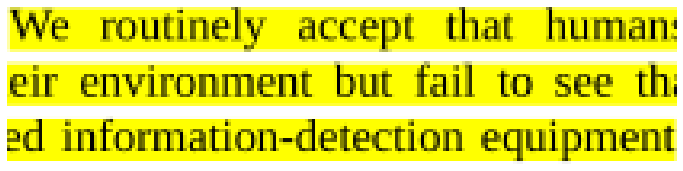

In [346]:
pix = pdf[21].getPixmap(clip=get_ver_corners(rects_vercs[0][0]))
im = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
plt.figure(figsize=(12,8))
plt.imshow(im)
plt.axis("off")

In [271]:
string = "Now, the PDF format is really odd. Annotations seem to be an after-thought to the format tacked on later."

In [272]:
import re

In [314]:
start = "the"
end = "tacked"
re.search('%s.*%s' % (start, end), string)[0]

'the PDF format is really odd. Annotations seem to be an after-thought to the format tacked'

In [182]:
annot1 = annots_rects[0]

In [183]:
annot1[1]

Rect(72.0, 179.3809814453125, 539.5759887695312, 227.030029296875)

In [184]:
vertices = annot1[0]

In [185]:
vertices

[(192.7010040283203, 179.3809814453125),
 (539.3729858398438, 179.3809814453125),
 (192.7010040283203, 192.469970703125),
 (539.3729858398438, 192.469970703125),
 (72.0, 196.6610107421875),
 (539.5759887695312, 196.6610107421875),
 (72.0, 209.75),
 (539.5759887695312, 209.75),
 (72.0, 213.94097900390625),
 (400.53399658203125, 213.94097900390625),
 (72.0, 227.030029296875),
 (400.53399658203125, 227.030029296875)]

In [187]:
last_word = max(vertices, key = lambda tup: (tup[1], tup[0])) # max y, then max x
last_word

(400.53399658203125, 227.030029296875)

In [240]:
rect = fitz.Rect(first_word, last_word)
rect

Rect(192.7010040283203, 179.3809814453125, 400.53399658203125, 227.030029296875)

In [199]:
page = pages[21]

In [204]:
words = page.getText("words")  # list of words on page

In [250]:
str_from_recr(rect, words)

'We routinely accept that humans their environment but fail to see that because of specialized information-detection equipment. So let me use another'

In [218]:
annot_text

'because\tof\tspecialized\tinformation-detection\tequipment.\tSo\tlet\tme\tuse\tanother'

In [157]:
while "  " in annot_text: annot_text = annot_text.replace("  ", " ")

page 21 of Boyer_2018_Minds-Make-Societies_ntvk.pdf

In [154]:
mywords

[]

In [ ]:
words = pdf[21].getText("words")
words.sort(key=lambda w: (w[3], w[0]))
words

In [165]:
pix = pdf[21].getPixmap(clip=first_word + last_word)

AttributeError: 'Pixmap' object has no attribute 'CropBox'

In [145]:
im = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)

(-0.5, 208.5, 48.5, -0.5)

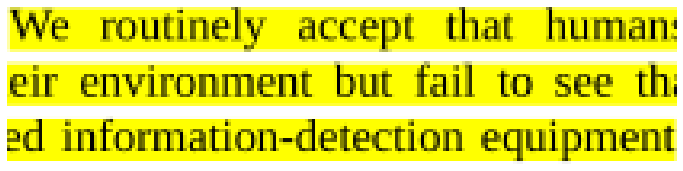

In [146]:
im = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
plt.figure(figsize=(12,8))
plt.imshow(im)
plt.axis("off")

In [212]:
[w for w in words if fitz.Rect(w[:4]).intersects(rect)]
group = groupby(mywords, key=lambda w: w[3])

In [33]:
import io # navigating files
from PIL import Image 
import pytesseract
from wand.image import Image as wi # working with PDFs and images
import cv2
import numpy as np
from wand.color import Color
import fitz
from matplotlib import pyplot as plt
import sddk

In [35]:
def pix2np(pix):
    im = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
    #im = np.ascontiguousarray(im[..., [2, 1, 0]])  # rgb to bgr
    return im

TypeError: Invalid shape (1454112,) for image data

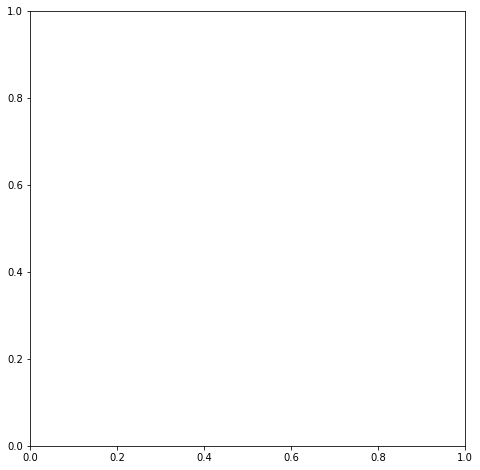

In [99]:
pix = pdf[21].getPixmap(annots_rects[0])
im = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)


plt.figure(figsize=(12,8))
plt.imshow(im)
plt.axis("off")

In [47]:
rect = np.array([72.0,  179.3809814453125, 539.5759887695312, 227.030029296875]).round()
rect
#im[rect]  #im[rect[0] : rect[3], rect[1]: rect[2]]

array([ 72., 179., 540., 227.])

In [48]:
h, w = im.shape[0], im.shape[1]
h, w

(792, 612)

In [53]:
im_rect = im[int(rect[0]):int(rect[1]), int(rect[3]):int(rect[2])]

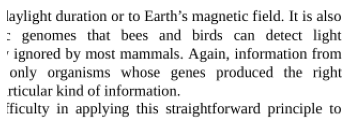

In [54]:
plt.imshow(im_rect)
plt.axis("off")
plt.show()


In [6]:
epub = fitz.open("The Making of the Abrahamic Religions in Late Antiquity Oxford Studies In Abrahamic Religions.epub")

mupdf: read error: Is a directory
mupdf: cannot recognize zip archive


RuntimeError: cannot recognize zip archive